In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from sklearn.model_selection import cross_val_score
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
import category_encoders as ce
from category_encoders import WOEEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
from sklearn.preprocessing import RobustScaler

In [4]:
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder, LeaveOneOutEncoder, JamesSteinEncoder, MEstimateEncoder

In [5]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


In [6]:
from mlxtend.plotting import plot_decision_regions

In [7]:
df = pd.read_csv('clean_data.csv')

In [8]:
pd.options.display.max_columns=100

In [9]:
df.drop(columns=['Unnamed: 0','funder','installer','construction_year'],inplace=True )

In [10]:
df1 = df.copy()

In [11]:
df1.drop(columns=['lga','ward'],inplace=True )

In [12]:
df1['permit'] = df1['permit'].astype(bool).astype(int)

In [13]:
df1['public_meeting'] = df1['public_meeting'].astype(bool).astype(int)

In [14]:
cat_col = ['basin','region','extraction_type_group','management','payment','water_quality','quantity',
               'source','waterpoint_type','decade','installer_cat','funder_cat']

In [15]:
num_col = ['gps_height','longitude','latitude','district_code','population','public_meeting','permit']

In [16]:
target_status_group = {0:0, 1: 1, 2 : 0}
df1['status_group'] = df1['status_group'].replace(target_status_group)

In [17]:
df1['status_group'].value_counts()

0    36576
1    22824
Name: status_group, dtype: int64

In [18]:
target='status_group'

In [19]:
encoder = TargetEncoder()
# #     encoder = LeaveOneOutEncoder()
# encoder = WOEEncoder()

# pipe = make_pipe(encoder, lr)

for c in cat_col:
    df1[str(c) + '_encoded'] = encoder.fit_transform(df1[c].values, df1[target])
    df1.drop(columns=c, inplace=True) 
    
# scaler = RobustScaler()

# encoder = ce.WOEEncoder(cols=cat_col)

# following steps will try later on to improve 
# Creating the separate transformers for numeric and categorical columns
# num_transformer = make_pipeline(scaler)
# cat_transformer = make_pipeline(encoder)

# # Defining preprocessor, which combines the two transformers
# preprocessor = ColumnTransformer(
#     transformers=[('num', num_transformer, num_col),
#                   ('cat', cat_transformer, cat_col)])

In [20]:
used_cols = [c for c in df1.columns.tolist() if c not in [target]]
X=df1[used_cols]
y=df1[target]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

TRAIN accuracy: 0.7580176767676767
TEST accuracy: 0.7613636363636364


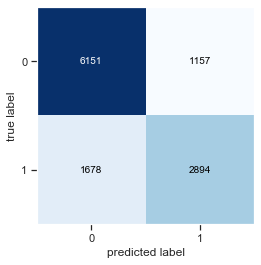

In [22]:
lr = LogisticRegression(class_weight = 'balanced', solver = 'lbfgs', random_state=42)

pipe = make_pipeline(lr)
pipe.fit(X_train, y_train)


# make predictions on training set
y_pred = pipe.predict(X_train)

# make predictions on test set
y_score = pipe.predict(X_test)

print("TRAIN accuracy:",accuracy_score(y_train, y_pred))
print("TEST accuracy:",accuracy_score(y_test, y_score))

cm = confusion_matrix(y_test, y_score)
plot_confusion_matrix(cm)
plt.show()

In [23]:
# train_preds = pipe.predict_proba(X_train)[:,1]
# test_preds = pipe.predict_proba(X_test)[:,1]

print("AUC:"); print("="*len("AUC:"))
print("TRAIN:", roc_auc_score(y_train, y_pred))
print("TEST:", roc_auc_score(y_test, y_score))

AUC:
====
TRAIN: 0.7350521360243188
TEST: 0.7373318636894526


In [24]:
coeffs = pipe['logisticregression'].coef_
coeffs

array([[-2.76799074e-05, -1.54923654e-01, -1.89981481e-02,
         6.48374324e-03, -3.54277034e-04, -8.28239760e-01,
        -2.83092901e-01,  3.22614612e-01,  8.54064594e-01,
         2.51461796e+00,  6.93960246e-01,  1.30792866e+00,
         8.16531998e-01,  4.24780902e+00,  6.88962816e-01,
         2.63349248e+00,  1.03837020e+00,  8.09081927e-01,
         7.92946042e-01]])

In [25]:
scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std()) #****

0.8027944952296313 +/- 0.003974480285374862


In [27]:

# clf = LogisticRegression(class_weight='balanced',random_state=42)
# pipe = make_pipeline(encoder, clf)

# scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
# print(scores.mean(), "+/-", scores.std())

0.8194321580289309 +/- 0.0038936016766233823


In [26]:
rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred)

0.9205729522076025

In [28]:
grid_p = {"n_estimators": [20, 50, 100],
          "criterion": ["gini", "entropy"],
          "max_features": ['sqrt', 'log2']}

grid_search = GridSearchCV(rf, grid_p, n_jobs=-1, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=50, n_jobs=-1,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'criterio

In [29]:
grid_search.best_score_

0.9190080653173771

In [30]:
grid_search.best_params_

{'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100}

In [31]:
best_rf = grid_search.best_estimator_

In [32]:
n_trees = best_rf.get_params()['n_estimators']

scores = cross_val_score(best_rf, X, y, cv=5, scoring='roc_auc') 
print(scores.mean(), "+/-", scores.std())

0.9211219639994503 +/- 0.002047811573765673


In [34]:
import xgboost
from xgboost import XGBClassifier

ModuleNotFoundError: No module named 'xgboost'

In [36]:
df_test = pd.read_csv('test_set_values.csv')

In [39]:
df_sub = pd.read_csv('SubmissionFormat.csv')

In [40]:
df_sub

,id,status_group
0,50785,predicted label
1,51630,predicted label
2,17168,predicted label
3,45559,predicted label
4,49871,predicted label
...,...,...
14845,39307,predicted label
14846,18990,predicted label
14847,28749,predicted label
14848,33492,predicted label
